In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
import numpy as np
import torchvision
from BNN import *
from spikingjelly.activation_based import functional

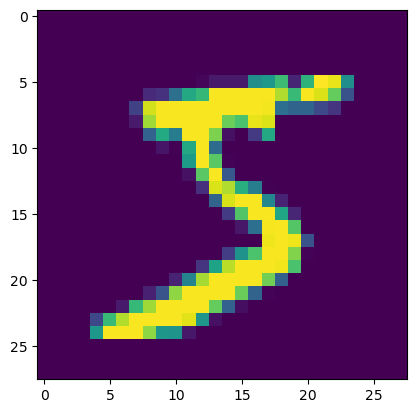

tensor([[[   0,    0,    0,    0,   21,   57,  316,  481,  758,  869,  795,
           374],
         [   0,   49,  606, 1360, 1993, 2405, 2844, 2813, 2546, 2308, 1726,
           672],
         [   0,   67, 1332, 2952, 4232, 4267, 4378, 3889, 3231, 2308, 1726,
           672],
         [   0,   67, 1346, 3121, 4723, 4726, 4435, 3416, 2602, 1439,  931,
           298],
         [   0,   18,  740, 1911, 3787, 3645, 2946, 1148,  685,    0,    0,
             0],
         [   0,    0,   14,  319, 1905, 2840, 3038, 2343, 1189,  202,    0,
             0],
         [   0,    0,    0,   11,  811, 2006, 3102, 3387, 2789, 1208,   64,
             0],
         [   0,    0,    0,    0,  187, 1092, 3095, 4638, 4119, 2077,   66,
             0],
         [   0,    0,   89,  693, 1837, 3149, 3997, 4554, 3968, 1978,   66,
             0],
         [ 227,  895, 1907, 3098, 3938, 4181, 4089, 3764, 2451,  972,    2,
             0],
         [ 616, 1790, 3013, 3846, 4034, 3913, 2952, 1661,  615,   78, 

In [2]:
#加载MNIST数据集
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='/home/curry/code', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='/home/curry/code', train=False, transform=transform, download=True)

#加载MNIST数据集的第一张图片
image, label = train_dataset[0]
#将图片用matplotlib画出来
import matplotlib.pyplot as plt
plt.imshow(image.squeeze().numpy())
plt.show()
#讲image转化为int8类型
image = image * 255
#print(image.int())

#用一个权重全为1的卷积核对图片进行卷积
conv1 = nn.Conv2d(1, 1, 5, 1, 0, bias=False)
conv2 = nn.Conv2d(1, 1, 5, 1, 0, bias=False)
relu1 = nn.ReLU()
conv1.weight.data.fill_(1)
conv2.weight.data.fill_(1)
output = conv1(image)
# print(output.shape)
# print(output.int())
pool = nn.MaxPool2d(2, 2)
fc = nn.Linear(192, 1,bias=False)
fc.weight.data.fill_(1)
output1 = relu1(output)
output2 = pool(output1)
print(output2.int())
output3 = conv2(output2)
print(output3.int())
output3 = relu1(output3)
output4 = pool(output3)
print(output4.int())
# output5 = output4.view(-1)
# output6 = fc(output5)
# print(output6.int())


# print(output2.shape)
# print(output2.int())
#将image转化为32位有符号
image_int = image.int()

#按行将image转化为txt文件
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_image_txt.txt', 'w') as f:
    for i in range(28):
        for j in range(28):
            f.write(format(image_int[0, i, j].item(), '032b') + '\n')
output_int = output.int()
print(output_int)
#按行将output转化为32位有符号整数的txt文件
# with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_output_txt.txt', 'w') as f:
#     for i in range(24):
#         for j in range(24):
#             value = output_int[0, i, j].item()
#             if value < 0:
#                 value = (1 << 32) + value  # 将负数转换为32位有符号整数的二进制表示
#             f.write(format(value, '032b') + '\n')
# output5_int = output5.int()
# #将output5转化为32位有符号整数的txt文件
# with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_output5_txt.txt', 'w') as f:
#     for i in range(192):
#         value = output5_int[i].item()
#         if value < 0:
#             value = (1 << 32) + value
#         f.write(format(value, '032b') + '\n')
#将output2转化为32位有符号整数的txt文件
output2_int = output2.int()
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_output2_txt.txt', 'w') as f:
    for i in range(12):
        for j in range(12):
            value = output2_int[0, i, j].item()
            if value < 0:
                value = (1 << 32) + value
            f.write(format(value, '032b') + '\n')

In [4]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10, T=4):
        super().__init__()
        self.T = T
        self.conv1 = BinaryConv2d(1, 6, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = BinaryConv2d(6, 12, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        self.fc1 = BinaryLinear(12*4*4, 10, bias=False)
        # self.relu3 = nn.ReLU()
        # self.fc2 = BinaryLinear(120, 84, bias=False)
        # self.relu4 = nn.ReLU()
        # self.fc3 = BinaryLinear(84, num_classes, bias=False)
    def forward(self, x):
        x = self.conv1(x)
        #print(x.int())
        #x = self.pool1(x)
        x = self.relu1(x)
        #print(x.int())
        x = self.pool1(x)
        #print(x.int())
        x = self.conv2(x)
        #print(x.int())
        #x = self.pool2(x)
        x = self.relu2(x)
        #print(x.int())
        x = self.pool2(x)
        #print(x.int())
        x = x.view(x.size(0), -1)
        #print(x.int())
        x = self.fc1(x)
        # x = self.relu3(x)
        # x = self.fc2(x)
        # x = self.relu3(x)
        # x = self.fc3(x)
        return x

In [5]:
net = LeNet()
print(net)
#将网络的权重初始化为-1
# for m in net.modules():
#     if isinstance(m, BinaryConv2d) or isinstance(m, BinaryLinear):
#         m.weight.data.fill_(1)
#加载权重
#net.load_state_dict(torch.load('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/train/weight/lenet_binary.pth'))
#将图片转化为网络的输入
image = image.unsqueeze(0)
output = net(image)
print(output.int())


LeNet(
  (conv1): BinaryConv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): BinaryConv2d(6, 12, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): BinaryLinear(in_features=192, out_features=10, bias=False)
)
tensor([[  1,  -2,  19, -13, -13, -16,   0, -21,  16,   8]], dtype=torch.int32)


In [6]:
x = torch.randn(128, 1, 28, 28)
y = net(x)
print(y.size())

torch.Size([128, 10])


In [19]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [8]:
from tqdm import tqdm
np.int = int
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
EPOCH = 10
device = torch.device('cuda:0')
net.to(device)
for epoch in range(EPOCH):
    net.train()
    for i ,data in enumerate(dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        functional.reset_net(net)
        if i % 100 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i,data in enumerate(testloader):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
torch.save(net.state_dict(), 'weight/lenet.pth')

[1,     1] loss: 2.297
[1,   101] loss: 0.460
[1,   201] loss: 0.515
[1,   301] loss: 0.424
[1,   401] loss: 0.395
Accuracy of the network on the 10000 test images: 92 %
[2,     1] loss: 0.282
[2,   101] loss: 0.245
[2,   201] loss: 0.369
[2,   301] loss: 0.222
[2,   401] loss: 0.139
Accuracy of the network on the 10000 test images: 94 %
[3,     1] loss: 0.160
[3,   101] loss: 0.170
[3,   201] loss: 0.176
[3,   301] loss: 0.151
[3,   401] loss: 0.057
Accuracy of the network on the 10000 test images: 94 %
[4,     1] loss: 0.214
[4,   101] loss: 0.152
[4,   201] loss: 0.177
[4,   301] loss: 0.166
[4,   401] loss: 0.121
Accuracy of the network on the 10000 test images: 94 %
[5,     1] loss: 0.234
[5,   101] loss: 0.191
[5,   201] loss: 0.188
[5,   301] loss: 0.305
[5,   401] loss: 0.138
Accuracy of the network on the 10000 test images: 96 %
[6,     1] loss: 0.131
[6,   101] loss: 0.168
[6,   201] loss: 0.213
[6,   301] loss: 0.194
[6,   401] loss: 0.092
Accuracy of the network on the 1000

In [4]:
class scale_Bconvd(BinaryConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(scale_Bconvd, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
    def forward(self, x):
        w = self.weight
        bw = BinaryWeight.apply(w)
        scaling_factor = torch.mean(torch.mean(torch.mean(torch.mean(abs(w),dim=3,keepdim=True),dim=2,keepdim=True),dim=1,keepdim=True),dim=0,keepdim=True)
        scaling_factor = scaling_factor.detach()
        #print(scaling_factor)
        # bw = scaling_factor * BinaryWeight.apply(w)
    
        return F.conv2d(x, bw, self.bias, self.stride,
                    self.padding, self.dilation, self.groups)
class scale_Blinear(BinaryLinear):
    def __init__(self, in_features, out_features, bias=False):
        super(scale_Blinear, self).__init__(in_features, out_features, bias)
        
    def forward(self, x):

        w = self.weight
        bw = BinaryWeight.apply(w)
        # print(w.shape)
        scaling_factor = torch.mean(torch.mean(abs(w),dim=1,keepdim=True),dim=0,keepdim=True)
        scaling_factor = scaling_factor.detach()
        #print(scaling_factor)
        # bw = scaling_factor * BinaryWeight.apply(w)
        
        return F.linear(x, bw, self.bias)

In [5]:
class scale_leNet(nn.Module):
    def __init__(self, num_classes=10, T=4):
        super().__init__()
        self.T = T
        self.conv1 = scale_Bconvd(1, 6, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = scale_Bconvd(6, 12, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        self.fc1 = scale_Blinear(12*4*4, 10, bias=False)
        # self.relu3 = nn.ReLU()
        # self.fc2 = scale_Blinear(120, 84, bias=False)
        # self.relu4 = nn.ReLU()
        # self.fc3 = scale_Blinear(84, num_classes, bias=False)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        # x = self.relu3(x)
        # x = self.fc2(x)
        # x = self.relu4(x)
        # x = self.fc3(x)
        return x

In [20]:
net = scale_leNet()
functional.set_step_mode(net, 'm')
print(net)
#加载权重
device = torch.device('cuda:0')
net.load_state_dict(torch.load('weight/lenet.pth',weights_only=True))
net.to(device)
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

scale_leNet(
  (conv1): scale_Bconvd(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): scale_Bconvd(6, 12, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): scale_Blinear(in_features=192, out_features=10, bias=False)
)
Accuracy of the network on the 10000 test images: 96 %


In [21]:
#将权重加载，二值化，保存为另外一个pth文件
net.load_state_dict(torch.load('weight/lenet.pth',weights_only=True))
for name, param in net.named_parameters():
    if 'weight' in name:
        param.data = BinaryWeight.apply(param.data)
torch.save(net.state_dict(), 'weight/lenet_binary.pth')
#加载二值化后的权重
net.load_state_dict(torch.load('weight/lenet_binary.pth',weights_only=True))
net.to(device)
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


In [23]:
#将网络第一层的权重导出
conv1_weight = net.conv1.weight.data
#print(conv1_weight)
conv1_weight = conv1_weight.view(-1)
#print(conv1_weight.shape)
conv1_weight_int = conv1_weight.int()
#print(conv1_weight_int)
#将第一层的权重导出为txt文件
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_conv1_weight_txt.txt', 'w') as f:
    for weight in conv1_weight_int:
        weight = weight.item()
        if weight < 0:
            weight = 0
        f.write(format(weight, 'b') + '\n')
#将网络第二层的权重导出
conv2_weight = net.conv2.weight.data
#print(conv2_weight.shape)
#print(conv2_weight)
conv2_weight = conv2_weight.view(-1)
#print(conv2_weight.shape)
conv2_weight_int = conv2_weight.int()
#print(conv2_weight_int)
#将第二层的权重导出为txt文件
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_conv2_weight_txt.txt', 'w') as f:
    for weight in conv2_weight_int:
        weight = weight.item()
        if weight < 0:
            weight = 0
        f.write(format(weight, 'b') + '\n')
#将网络第三层的权重导出
fc1_weight = net.fc1.weight.data
print(fc1_weight)
print(fc1_weight.shape)
fc1_weight = fc1_weight.view(-1)
print(fc1_weight.shape)
fc1_weight_int = fc1_weight.int()
print(fc1_weight_int)
#将第三层的权重导出为txt文件
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_fc1_weight_txt.txt', 'w') as f:
    for weight in fc1_weight_int:
        weight = weight.item()
        if weight < 0:
            weight = 0
        f.write(format(weight, 'b') + '\n')
    

tensor([[ 1.,  1.,  1.,  ..., -1., -1., -1.],
        [ 1.,  1., -1.,  ..., -1.,  1.,  1.],
        [ 1.,  1.,  1.,  ..., -1., -1.,  1.],
        ...,
        [ 1., -1.,  1.,  ...,  1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ...,  1., -1., -1.]], device='cuda:0')
torch.Size([10, 192])
torch.Size([1920])
tensor([ 1,  1,  1,  ...,  1, -1, -1], device='cuda:0', dtype=torch.int32)


In [17]:
class watch_scale_leNet(nn.Module):
    def __init__(self, num_classes=10, T=4):
        super().__init__()
        self.T = T
        self.conv1 = scale_Bconvd(1, 6, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = scale_Bconvd(6, 12, kernel_size=5, stride=1, padding=0, bias=False)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        self.fc1 = scale_Blinear(12*4*4, 10, bias=False)
        # self.relu3 = nn.ReLU()
        # self.fc2 = scale_Blinear(120, 84, bias=False)
        # self.relu4 = nn.ReLU()
        # self.fc3 = scale_Blinear(84, num_classes, bias=False)
    def forward(self, x):
        x = self.conv1(x)
        print(self.conv1.weight)
        x = self.relu1(x)
        x = self.pool1(x)
        print(x.int())
        x = self.conv2(x)
        print(self.conv2.weight)
        print(x.int())
        x = self.relu2(x)
        x = self.pool2(x)
        print(x.int())
        x = x.view(x.size(0), -1)
        print(x.int())
        print(self.fc1.weight[0])
        x = self.fc1(x)
        # x = self.relu3(x)
        # x = self.fc2(x)
        # x = self.relu4(x)
        # x = self.fc3(x)
        return x

net = watch_scale_leNet()
net.load_state_dict(torch.load('weight/lenet_binary.pth',weights_only=True))
image, label = train_dataset[0]
image = image*255
image = image.unsqueeze(0)
output = net(image)
print(output.int())


Parameter containing:
tensor([[[[-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1., -1.],
          [ 1.,  1.,  1., -1., -1.]]],


        [[[-1., -1., -1., -1.,  1.],
          [-1., -1., -1., -1.,  1.],
          [-1., -1.,  1.,  1.,  1.],
          [-1.,  1.,  1.,  1.,  1.],
          [ 1.,  1., -1.,  1., -1.]]],


        [[[ 1.,  1.,  1., -1., -1.],
          [ 1.,  1.,  1.,  1., -1.],
          [ 1.,  1.,  1., -1., -1.],
          [ 1.,  1.,  1., -1., -1.],
          [-1., -1., -1., -1., -1.]]],


        [[[ 1.,  1.,  1.,  1.,  1.],
          [ 1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1.,  1.],
          [-1., -1.,  1.,  1.,  1.]]],


        [[[-1., -1., -1., -1., -1.],
          [ 1.,  1., -1., -1., -1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [-1.,  1.,  1.,  1.,  1.],
          [-1., -1., -1., -1., -1.]]],


        [[[ 1.,  1.,  1.,  1., -1

In [10]:
#对conv1的权重进行赋值
weight_conv1 = torch.tensor([[-1,-1,-1,-1,-1],[-1,-1,-1,-1,1],[1,1,1,1,1],[1,1,1,1,-1],[1,1,1,-1,-1]])
with torch.no_grad():
    conv1.weight.copy_(weight_conv1)
out1 = conv1(image)
print(out1.int())
out2 = relu1(out1)
out3 = pool(out2)
print(out3)

tensor([[[[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [    0,     0,     0,     0,     0,     0,     0,     0,    -3,   -21,
             -33,   -15,  -105,  -208,  -149,    79,   245,   -84,  -135,    73,
             541,   629,   374,   127],
          [    0,     0,     0,     0,   -30,   -66,  -100,  -182,  -167,  -154,
             -85,    92,   101,   297,   404,   791,   603,   403,   588,   975,
            1421,  1130,   633,   191],
          [    0,     0,     0,   -49,  -317,  -448,  -247,    40,   385,   475,
             710,   887,  1112,  1330,  1675,  1875,  1712,  1707,  1728,  1800,
            1726,  1225,   672,   191],
          [    0,     0,     0,   -67,  -396,  -354,   178,   838,  1450,  1734,
            1988,  2200,  2285,  2127,  2417,  2165,  1944,  1590,   986,   618,
             136,   -33,   -76

In [15]:
watch_conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0, bias=False)
watch_conv1_weight = net.conv1.weight.int()
watch_conv2 = nn.Conv2d(6, 12, kernel_size=5, stride=1, padding=0, bias=False)
watch_conv2_weight = net.conv2.weight.int()
#print(watch_conv2_weight)
#watch_conv2_weight = watch_conv2_weight
#print(watch_conv2_weight)
with torch.no_grad():
    watch_conv1.weight.copy_(watch_conv1_weight)
    watch_conv2.weight.copy_(watch_conv2_weight)
image, label = train_dataset[0]
image = 255*image

out = watch_conv1(image)
out = relu1(out)
out = pool(out)
out = watch_conv2(out)
print(out.int())
out = relu1(out)
out = pool(out)
out = out.view(-1)
out_int = out.int()
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_output5_txt.txt', 'w') as f:
    for i in range(192):
        value = out_int[i].item()
        f.write(format(value, '032b') + '\n')
#将test_output5_txt.txt每格16行单独提取出来，放到不同的txt文件中
with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_output5_txt.txt', 'r') as f:
    lines = f.readlines()
    for i in range(12):
        with open('/home/curry/code/curry_code_summay/rtl_works/BNN_on_fpga/test_output5_txt' + str(i) + '.txt', 'w') as f:
            for j in range(16):
                f.write(lines[i*16 + j])
fc = nn.Linear(192, 1,bias=False)
fc_weight = net.fc1.weight[0].int()
print(fc_weight)
with torch.no_grad():
    fc.weight.copy_(fc_weight)
out = fc(out)
print(out.int())

tensor([[[  2725,   1597,  -6894, -11001, -10972,  -8441,  -1208,    820],
         [  1008,   6654,   2989,   4241,     99,  -2269,   8128,  17356],
         [  -167,  13935,  16025,   7174,   3032, -12581, -15282,   -408],
         [ -3023,   5814,  16190,  11842,   7087,  -9093, -28395, -20068],
         [ -8031,  -7586,   1019,      1,   -442,   2158,    251,  -9298],
         [-11323, -17918, -15966,  -6931,    263,  -1147,   2772,   -295],
         [-23309, -23291, -23331, -14467,  -1684,  -7176,  -9618,   -374],
         [-12255, -17007, -20372, -18343,  -7205,   4357,   5115,   4544]],

        [[-21189, -29113, -27850, -33557, -34498, -34501, -28600, -25266],
         [-17078, -29568, -26629, -12889,  -7589,  -9615,  -6798,  -5956],
         [ 10621,  -1409,  -7479,  -3764,  11692,  10563,   4918,  -3382],
         [  7255,   2280, -13660, -24750, -12857,    897,  10821,  11628],
         [  3363,   6984,   5441,  -9525, -26232, -19164,  -6507,   3858],
         [  5007,  1301